# Explore the Experimental Datasets (Brij, Poberski)


In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
from typing import List

import matplotlib.pyplot as plt
import seaborn as sns

import farmhash

import NegativeClassOptimization.utils as utils
import NegativeClassOptimization.config as config
from NegativeClassOptimization import preprocessing, pipelines, visualisations

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [3]:
alphabet = config.AMINOACID_ALPHABET+["*", "X"]

# Brij

- CDRH3 here have length of 10!

In [4]:
### Read all the "csv" files from the directory in 
###  a single dataframe
def read_csvs_from_brij(dir_path: Path) -> pd.DataFrame:
    csv_paths = list(dir_path.glob("*.csv"))
    dfs = []
    for csv_path in csv_paths:
        df = pd.read_csv(csv_path)

        # Append filename w/o extension as column to the df
        df["filename"] = csv_path.stem
        df["binder_type"] = csv_path.stem.split("_")[1]

        dfs.append(df)
    return pd.concat(dfs)

df = read_csvs_from_brij(config.DATA_BRIJ_DIR)

### Some basic checks:
# 1) all aa_cdr3_seq are length 11
df["aa_cdr3_seq_len"] = df["aa_cdr3_seq"].apply(len)
assert df["aa_cdr3_seq_len"].unique() == [10]

# 2) all aa_cdr3_seq are unique
assert df["aa_cdr3_seq"].nunique() == df.shape[0]

# 3) all aa_cdr3_seq are valid amino acids
assert df["aa_cdr3_seq"].apply(
    lambda seq: all([char in config.AMINOACID_ALPHABET for char in seq])
    ).all()

### Map hb,mb,lb to _high, _Xlooser, _95low
df["binder_type"] = df["binder_type"].map({
    "hb": "HR2B_high",
    "mb": "HR2B_looserX",
    "lb": "HR2B_95low"
})

### Display
print(df.shape)
print(df["binder_type"].value_counts())
df.head()

(524346, 5)
HR2B_looserX    190011
HR2B_high       172149
HR2B_95low      162186
Name: binder_type, dtype: int64


,aa_cdr3_seq,count,filename,binder_type,aa_cdr3_seq_len
0,IASVAFTCSL,14426,Unique_lb,HR2B_95low,10
1,IASGLLTLYH,10086,Unique_lb,HR2B_95low,10
2,WATFGLYAHR,9139,Unique_lb,HR2B_95low,10
3,WSMFGLYTFC,8237,Unique_lb,HR2B_95low,10
4,YVTNGFYAYH,8063,Unique_lb,HR2B_95low,10


In [5]:
### Adapt df to fit as much as possible
### the format we used with Absolut data.
# ID_slide_Variant	CDR3	Best	Slide	Energy	Structure	Source	Antigen
df["ID_slide_Variant"] = None
df["CDR3"] = df["aa_cdr3_seq"]
df["Best"] = True
df["Slide"] = df["aa_cdr3_seq"]
df["Energy"] = None
df["Structure"] = None
df["Source"] = df["binder_type"]
df["Antigen"] = "HR2B"
df = df[["ID_slide_Variant", "CDR3", "Best", "Slide", "Energy", "Structure", "Source", "Antigen", "binder_type"]].copy()

# Check no duplicates
assert df["CDR3"].duplicated().sum() == 0, "There are duplicated CDR3s"

In [6]:
### Code adapted from "miniabsolut" command
### from script_01*.py.
### Main points:
###  - Save the results in the Miniabsolut directory structure!
###  - Use "save_train_test_rest" function
###  - There are no duplicates in the Brij dataset

def build_dataset_into_Absolut(N_train, N_test, MAKE_SPLITS, seed, ag, df):
    if MAKE_SPLITS:
        base_p = Path(config.DATA_MINIABSOLUT_SPLITS) / f"MiniAbsolut_Seed{seed}"
        base_p.mkdir(exist_ok=True, parents=False)
    else:
        base_p = config.DATA_MINIABSOLUT
        base_p.mkdir(exist_ok=True, parents=False)


    ag_dir = base_p / ag
    ag_dir.mkdir(exist_ok=True, parents=False)

    # Get the high binders.
    df_high = df[df["binder_type"] == f"{ag}_high"].copy()
    df_high.drop(columns=["binder_type"], inplace=True)
    df_train, df_test, df_rest = utils.split_to_train_test_rest_dfs(
        N_train,
        N_test,
        df_high,
        random_state=seed,
    )
    # utils.save_train_test_rest(
    #     "high", N_train, N_test, ag_dir, df_train, df_test, df_rest
    # )
    ## Hack to fit naming of files.
    ## Even though for some experimental datasets,
    ## such as Porebski, we don't have 15k and 5k sequences,
    ## it makes our life much easier to preserve the naming.
    utils.save_train_test_rest(
        "high", 15000, 5000, ag_dir, df_train, df_test, df_rest
    )

    # Get the weak binders
    df_weak = df[df["binder_type"] == f"{ag}_looserX"].copy()
    df_weak.drop(columns=["binder_type"], inplace=True)
    df_train, df_test, df_rest = utils.split_to_train_test_rest_dfs(
        N_train,
        N_test,
        df_weak,
        random_state=seed,
    )
    # See note from above for explaining the 2 numbers.
    utils.save_train_test_rest(
        "looserX", 15000, 5000, ag_dir, df_train, df_test, df_rest
    )

    # Get the nonbinders
    df_nonbinder = df[df["binder_type"] == f"{ag}_95low"].copy()
    df_nonbinder.drop(columns=["binder_type"], inplace=True)
    df_train, df_test, df_rest = utils.split_to_train_test_rest_dfs(
        N_train,
        N_test,
        df_nonbinder,
        random_state=seed,
    )
    # See note from above for explaining the 2 numbers.
    utils.save_train_test_rest(
        "95low", 15000, 5000, ag_dir, df_train, df_test, df_rest
    )

In [7]:
# Run and build into the Absolut dataset
# the new experimental data from Brij.

RUN_FLAG = False

if RUN_FLAG:
    ag = "HR2B"  # Her2 from Brij dataset
    df = df.copy()

    N_train = 15000
    N_test = 5000

    make_splits = [False] + [True]*5
    seed = [None] + list(range(5))

    for MAKE_SPLITS, seed in zip(make_splits, seed):
        build_dataset_into_Absolut(N_train, N_test, MAKE_SPLITS, seed, ag, df)

In [8]:
slides_high = df.loc[df["binder_type"] == "HR2B_high", "CDR3"].values
slides_weak = df.loc[df["binder_type"] == "HR2B_looserX", "CDR3"].values
slides_nonb = df.loc[df["binder_type"] == "HR2B_95low", "CDR3"].values

jsd_1 = utils.jensen_shannon_divergence_slides(slides_high, slides_weak)
jsd_2 = utils.jensen_shannon_divergence_slides(slides_high, slides_nonb)
jsd_3 = utils.jensen_shannon_divergence_slides(slides_weak, slides_nonb)
print(jsd_1, jsd_2, jsd_3)

2.623701768613825 2.8299173312573656 2.3068467051017545


# Porebski

@eugen
- it looks like "intensity 8" values are some exponential (Kd?), taking log helps! E ~ ln(Kd)

$$
\frac{Intensity-F_{min}}{F_{max}} = \frac{1}{(1 + \frac{K_d}{c})}
$$

$$
\text{Fractional Occupancy} = \frac{[LR]}{R_T} = \frac{1}{(1 + \frac{K_d}{c})}
$$

@puneet
1. The binding intensities for the first 9 intensity columns seems to be at different concentration: 100 pM, 333 pM, 1 nM, 3.33 nM, 10 nM, 33.3 nM and 100 nM  followed by measurement after using wash buffer at 5 minutes, 10 minutes, 20 minutes, 60 minutes, 240 minutes and 420 minutes. (although the number of columns do not match with given concentration/waash step; there are 2 extra columns)... However, Based on number of High-hit sequences "intensity 8" column matches with their data, where 232,693 non-hit, 1,284 low hit and 111 high hit sequences are present (but again low and non hit numbers do not match.)
2. For consistency we can use "intensity 8" column to benchmark our method... We can use our own criteria of top 1% as high binders since their threshold is also arbitrary.
3. There are duplicates and sequences with stop codon in CDRH3 sequences. So we need to remove the sequences containing ' * (star sign) ' from the dataset. For the duplicates, they mention the mean values in the paper but looking at the dataset, they have taken the first instance of the CDRH3. It is upto us, if we take mean or first instance.
4. I have also attached the histogram of intensity values for both AffMat and ML_lib dataset, for reference.
5. While using the ML_lib dataset, Please make sure to remove the duplicate sequences from AffMat dataset. other filtering criteria are same.
6. AffMat dataset is affinity matured variants of G98A (moderate affinity) variant and top results of AffMat were used to generate ML_lib dataset.

In [9]:
df_affmat = pd.read_csv(config.DATA_POREBSKI_AFFMAT)
df_mllib = pd.read_csv(config.DATA_POREBSKI_MLLIB)

(297655, 17)


,barcode,read 1,intensity 0,intensity 1,intensity 2,intensity 3,intensity 4,intensity 5,intensity 6,intensity 7,intensity 8,intensity 9,intensity 10,intensity 11,intensity 12,intensity 13,intensity 14
0,ACGTACGGAACGACTGGGAATCGGGAAA,HDVAYC*NGVCAKWPEYFQHW,111.162155,114.214165,108.445620,121.60841,111.210010,108.283430,106.91365,108.11853,107.43973,110.823685,102.622536,104.62107,108.08731,116.48155,113.976555
1,AAAGCCTTTGTCTTAATTCTTACGTAGT,HDVAYCVRQICAKWPEYFQHW,120.183655,109.137960,111.790860,103.05037,106.810104,116.476010,103.22357,109.03449,114.20926,117.268430,133.590450,133.51840,135.52965,115.18586,115.041420
2,CCTGTTACGATGCTAAGCTTAGACCGTT,LV*VYCSSSNCAKWPEYFQHW,103.966064,113.868900,118.207375,111.84847,115.555240,113.934040,115.70354,106.53288,111.22044,124.952820,113.261215,114.28279,116.65958,128.31450,121.338620
3,CGGACCATGGAGTCCGGGAAGTGTTTGG,HDVAYCSSSLRTQWPEYFQHW,127.545265,117.569750,115.094070,129.37624,109.038530,116.028620,111.39108,121.91439,136.57323,133.031510,111.147930,115.46255,128.40411,110.14575,101.833020
4,GCCTATTGGCTCACCCCATAAGTTCAAG,*FIFYCSSSNCAKWPEYFQHW,113.597500,114.514046,113.679886,117.84018,112.747510,113.616936,106.08342,121.21106,124.36789,111.603150,117.928800,121.20863,112.65758,118.85942,114.777820


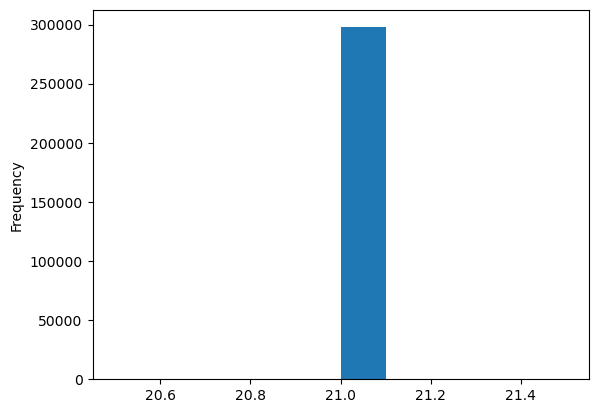

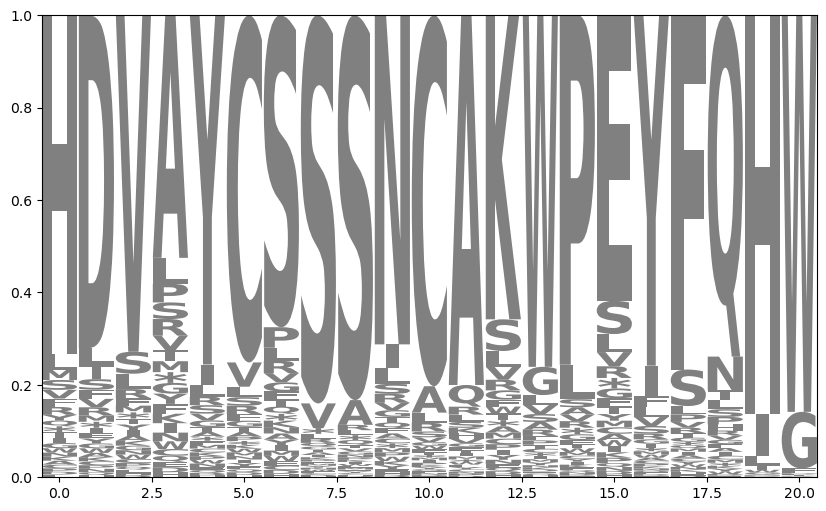

In [10]:
print(df_affmat.shape)
df_affmat["read 1"].apply(len).plot.hist()

pwm_affmat = utils.pwm(df_affmat["read 1"].values, alphabet=alphabet)
df_pwm_affmat = pd.DataFrame(pwm_affmat, columns=alphabet)
visualisations.plot_logo(df_pwm_affmat, allow_other_shape=True)

df_affmat.head()

(2688992, 16)


,barcode,read 1,intensity 0,intensity 1,intensity 2,intensity 3,intensity 4,intensity 5,intensity 6,intensity 7,intensity 8,intensity 9,intensity 10,intensity 11,intensity 12,intensity 13
0,GGTGTTGGCGGCAACGTTAGTGGGAATT,HDFSYCSSQRCLTKPEYRQHW,108.02723,107.82694,104.722460,101.310620,111.767654,107.21744,106.752360,101.631110,120.037160,110.891890,117.107220,115.272820,105.646740,114.811740
1,GCTGTTGCTCCATTCCTCTCTGATTAAA,HDGAYCDTPTCAKWPEYTQHW,112.99632,109.07194,116.466450,106.410140,107.501940,112.37337,115.151660,116.407555,105.732920,109.001114,107.154020,115.674510,107.512665,104.302444
2,AGGATCCCTCTGGTTGGGGGGCGGTAGA,HDVAESDTPSCAKAPEYFQHW,112.98326,114.39684,105.212814,107.094864,121.108530,104.15204,107.106064,112.058105,108.922470,104.445510,103.450610,109.909260,104.636460,111.820890
3,TATAAGTTTAGTATGTGATTTTATCGTG,HDVGYCSSSRCLTWPELFQNW,103.36806,105.89001,111.813934,104.223260,109.513800,114.80756,112.688750,139.362820,109.053764,113.665660,115.736310,110.517440,109.276620,117.396080
4,CTTATGAAAGCCAGGGTCGGGTGGGAAC,HDVAKCSMSRCLTWPEYFQHW,120.16611,111.83368,103.726110,93.933800,100.159220,99.80600,119.560270,99.477920,120.024315,114.806080,100.436714,117.578735,104.131730,112.085500


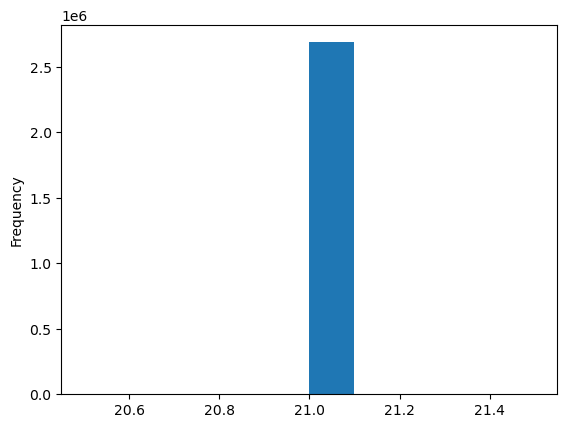

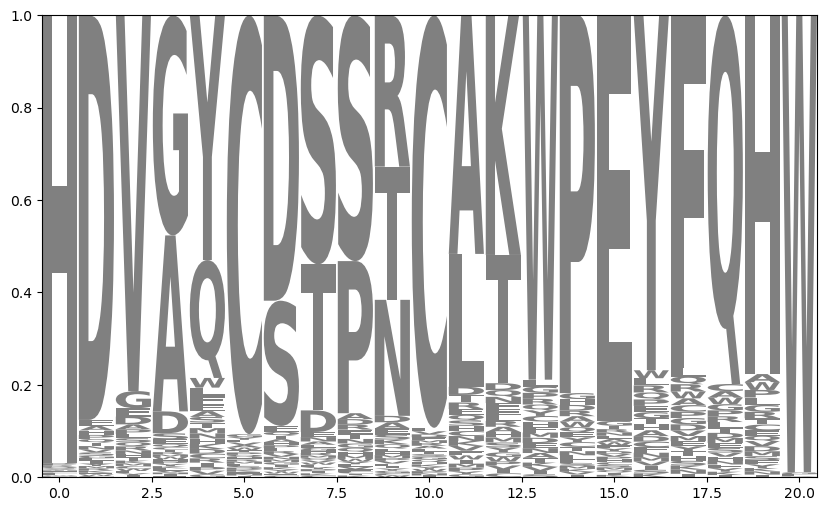

In [11]:
print(df_mllib.shape)
df_mllib["read 1"].apply(len).plot.hist()

pwm_mllib = utils.pwm(df_mllib["read 1"].values, alphabet=alphabet)
df_pwm_mllib = pd.DataFrame(pwm_mllib, columns=alphabet)
visualisations.plot_logo(df_pwm_mllib, allow_other_shape=True)

df_mllib.head()

Unique barcodes and CDR3H in mllib == nrows => UMIs from paper are given by the "read 1", which is the CDRH3.

In [12]:
# Each row unique barcode
print(df_mllib.shape)
print("Num unique barcodes: ", df_mllib["barcode"].nunique())
print("Num unique reads: ", df_mllib["read 1"].nunique())

(2688992, 16)
Num unique barcodes:  2688992
Num unique reads:  199741


In [13]:
# Num peptides that have * or "X"
print("Num peptides that have * or X: ", sum("*" in seq or "X" in seq for seq in df_mllib["read 1"].unique()))

# Remove peptides that have * or "X"
df_mllib_clean = df_mllib[~df_mllib["read 1"].map(lambda seq: "*" in seq or "X" in seq)]
print("Num peptides that have * or X in cleaned: ", sum("*" in seq or "X" in seq for seq in df_mllib_clean["read 1"].unique()))

# Keep peptides that have >= 12 replicates
df_mllib_clean = df_mllib_clean.groupby("read 1").filter(lambda x: len(x) >= 12)

Num peptides that have * or X:  8577
Num peptides that have * or X in cleaned:  0


HDVAYCSSSNCAKWPEYFQHW    2265
HDVAYCDTPTCAKWPEYFQHW    1465
HDVGYCDTPTCAKWPEYFQHW    1128
HDVGYCSSSRCLTWPEYFQHW    1049
HDVGQCDSSNCAKWPEYFQHW    1007
                         ... 
HDAGQCDSSSCASWPEYFQHW      12
HDSAWCDTPTCAQWPEYFQHW      12
HDVDYCDTPQCVKGPEYFQHW      12
HDVGQCDSSRCAKWPENFDPW      12
HDVADCDTMTFRKWPEYFQHW      12
Name: read 1, Length: 24790, dtype: int64


<AxesSubplot: ylabel='Frequency'>

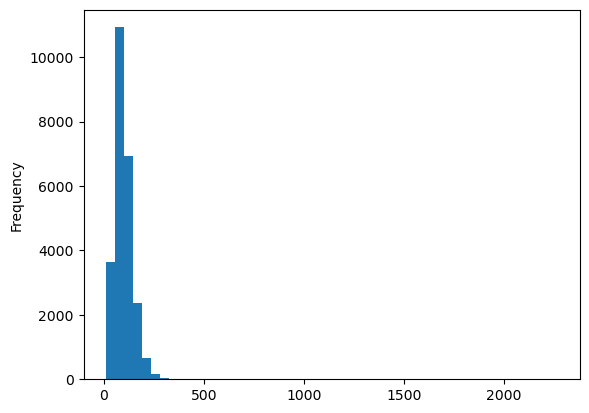

In [14]:
# Distribution of num peptides
cdrh3_counts = df_mllib_clean["read 1"].value_counts()
print(cdrh3_counts)
cdrh3_counts.plot.hist(bins=50)

In [15]:
# Num peptides with replicates >= 12
print("Num peptides with replicates >= 12: ", (cdrh3_counts >= 12).sum())

Num peptides with replicates >= 12:  24790


Compare affmat with mllib distributions

(0.0, 300.0)

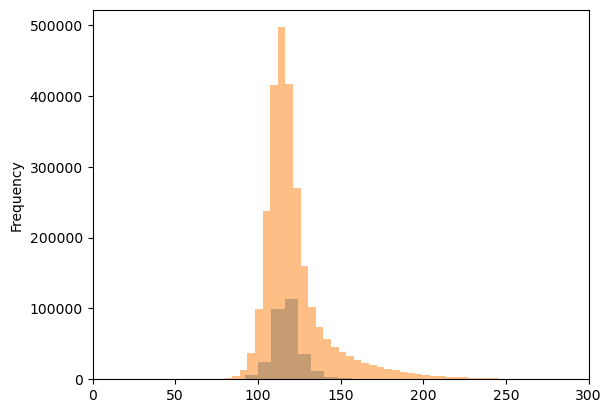

In [16]:
# Plot distribution of "Intensity 8" for both the dataframes
# in the same plot.
df_affmat["intensity 8"].plot.hist(bins=1000, alpha=0.5)
df_mllib["intensity 8"].plot.hist(bins=1000, alpha=0.5)
plt.xlim(0, 300)

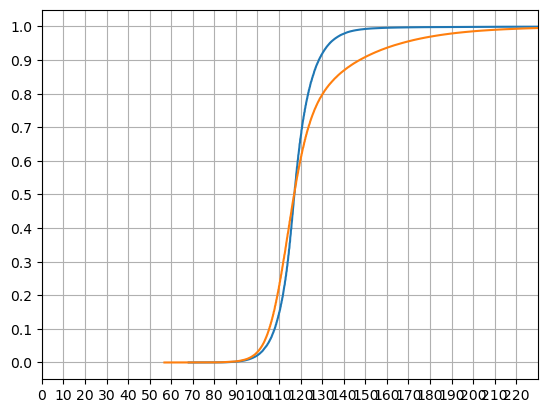

In [17]:
# Get CDF at 0.01 interval for both the dataframes
# (better plot than quantiiles)
cdf_affmat = df_affmat["intensity 8"].value_counts(normalize=True).sort_index().cumsum()
cdf_mllib = df_mllib["intensity 8"].value_counts(normalize=True).sort_index().cumsum()

# Plot CDFs
cdf_affmat.plot()
cdf_mllib.plot()
plt.grid()
plt.xlim(0, 230)
plt.xticks(range(0, 230, 10));
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]);

# quantiles_affmat = df_affmat["intensity 8"].quantile(
#     q=[0.01*i for i in range(100)]
# )
# quantiles_mllib = df_mllib["intensity 8"].quantile(
#     q=[0.01*i for i in range(100)]
# )

# # Plot quantiles
# quantiles_affmat.plot()
# quantiles_mllib.plot()
# plt.grid()
# # Switch x-axis with y-axis

In [18]:
print((df_mllib["intensity 8"] > 230).sum())
print(df_mllib.shape[0])

12567
2688992


<AxesSubplot: ylabel='Frequency'>

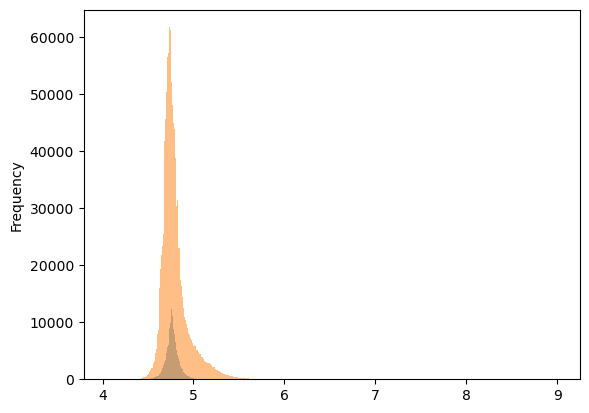

In [19]:
### Log version
# Plot distribution of "Intensity 8" for both the dataframes
# in the same plot.
df_affmat["intensity 8"].apply(np.log).plot.hist(bins=1000, alpha=0.5)
df_mllib["intensity 8"].apply(np.log).plot.hist(bins=1000, alpha=0.5)

<AxesSubplot: ylabel='Frequency'>

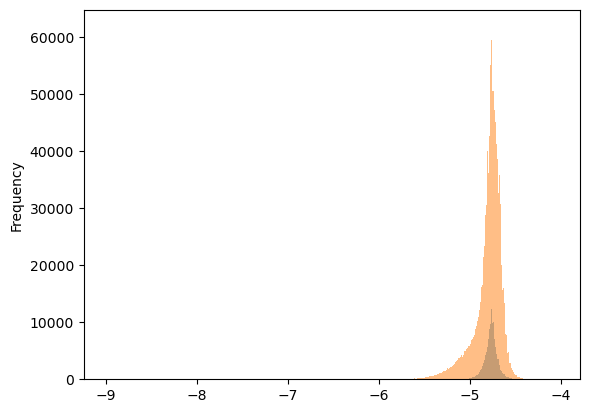

In [20]:
df_affmat["intensity 8"].apply(lambda x: np.log(1/x)).plot.hist(bins=1000, alpha=0.5)
df_mllib["intensity 8"].apply(lambda x: np.log(1/x)).plot.hist(bins=1000, alpha=0.5)

## First principles understanding of the data

In [21]:
def GaussianTwoDimensions(size, sigma = 1):
    """
    From https://github.com/holliger-lab/DeepScreening/blob/main/analysis-src/detect_extract_pipeline.py
    """
    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]

    c_x = c_y = size // 2

    return 1*np.exp(-((((c_x-x)**2)/(2*sigma**2))+(((c_y-y)**2)/(2*sigma**2))))


# One can use the PSF from above to compute the max intensity, but not
# relevant for our use case.
# > multiply PSF with a 9x9 matrix of 2**16 and sum all elements
PSF = GaussianTwoDimensions(9, sigma=0.5)
PSF = PSF * (2**16)
PSF.sum()

105926.44405932081

The intensity values are according to Fig. 4e. My suspicion, first value is without adding the antigen. Next 7 values are by increasing the concentrations (45' to reach steady state). The next values (6 for affmat, 7 for mllib) are obtained by measuring dissociation at specific sequence of time points. 

- Why I think the first value is without adding the antigen?
    - see below statistical test that intensity 1 > 0, intensity 7 > 6.
- One can fit for Kd from the first values.
- The dissociation curves were fit according to a biphasic dissociation model, but not of interest to us.
- Note that Fig. 4e second plot finishes at about 7-8k seconds, but there are clear time points above this (from methods).
- Overall the dataset is badly documented.
- 

In [22]:
(df_mllib_clean["read 1"] == "HDFSYCSSQRCLTKPEYRQHW").sum(), (df_mllib_clean["barcode"] == "GGTGTTGGCGGCAACGTTAGTGGGAATT").sum()

(139, 1)

/tmp/ipykernel_269019/2499369911.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(


,barcode,read 1,intensity 0,intensity 1,intensity 2,intensity 3,intensity 4,intensity 5,intensity 6,intensity 7,intensity 8,intensity 9,intensity 10,intensity 11,intensity 12,intensity 13
0,GGTGTTGGCGGCAACGTTAGTGGGAATT,HDFSYCSSQRCLTKPEYRQHW,108.027230,107.826940,104.722460,101.31062,111.767654,107.217440,106.752360,101.631110,120.03716,110.89189,117.107220,115.272820,105.64674,114.81174
2527,AAAGGGTGTCCCCGATCTCATTCGAATT,HDFSYCSSQRCLTKPEYRQHW,114.847720,110.212204,99.671320,94.06001,118.557816,116.990010,109.304184,112.841415,111.20302,101.83650,116.727425,118.147995,114.81029,110.79744
4249,TCGAGTTGGTCTCAATTCCTGGGGAGTT,HDFSYCSSQRCLTKPEYRQHW,111.532800,114.336020,108.940636,114.26729,117.264220,121.664120,116.752120,112.257330,107.47253,118.17296,113.744000,118.885864,115.44645,113.83032
7693,CTGATATGGCAGTACTAGTCTTCCCTTA,HDFSYCSSQRCLTKPEYRQHW,105.901215,95.823654,108.375984,108.94354,111.166466,112.402640,112.995575,129.588780,118.77344,114.80075,103.331540,108.531840,115.11480,104.32440
18750,TGTATGTTGAATTTTATTATTAAGGATT,HDFSYCSSQRCLTKPEYRQHW,103.460620,111.116270,109.891880,118.88193,121.505165,106.405945,121.080215,113.632720,95.84775,113.61243,121.593050,108.668040,104.06820,119.02379


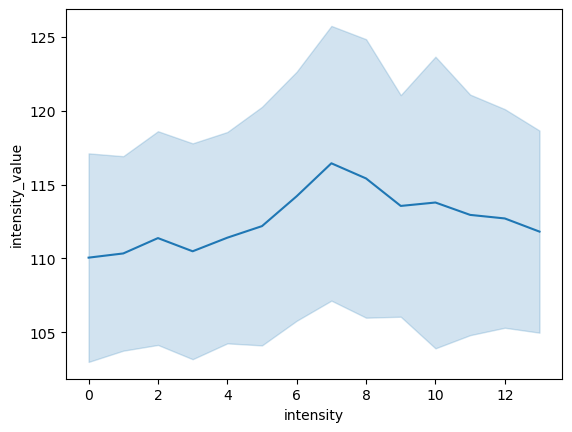

In [23]:
df_c = df_mllib_clean[df_mllib_clean["read 1"] == "HDFSYCSSQRCLTKPEYRQHW"].copy()

# Plot line plot with aggregated data over all
# the columns "intensity 0" to "intensity 13"
# by melting the columns and then seaborn.
df_c_melted = df_c.melt(
    id_vars=["read 1", "barcode"],
    value_vars=[f"intensity {i}" for i in range(14)],
    var_name="intensity",
    value_name="intensity_value"
)
df_c_melted["intensity"] = df_c_melted["intensity"].apply(lambda x: int(x.split(" ")[1]))
sns.lineplot(
    data=df_c_melted,
    x="intensity",
    y="intensity_value",
    ci="sd"
)

df_c.head()

To show that first value is probably at no antigen, we check intensity 0 vs 1, and 6 vs 7, per peptide.
- Although we don't see a clear difference between 0 and 1, we do see a clear difference between 6 and 7, indicating that 7 is the max!
- We also see that 6 < 7 > 8 => 7 is the max!

In [24]:
# To show that first value is probably at no antigen, 
# we check intensity 0 vs 1, and 6 vs 7, per peptide ("read 1")
# using student t-test.
# Note: t-test statistic is 1st group vs 2nd group.

from scipy import stats

records = []
for cdr3, df_g in df_mllib_clean.groupby("read 1"):
    m_0 = df_g["intensity 0"].mean()
    m_1 = df_g["intensity 1"].mean()
    m_6 = df_g["intensity 6"].mean()
    m_7 = df_g["intensity 7"].mean()
    m_8 = df_g["intensity 8"].mean()
    t1 = stats.ttest_ind(df_g["intensity 0"], df_g["intensity 1"])
    t2 = stats.ttest_ind(df_g["intensity 6"], df_g["intensity 7"])
    t3 = stats.ttest_ind(df_g["intensity 7"], df_g["intensity 8"])
    record = {
        "cdr3": cdr3,
        "m_0": m_0,
        "m_1": m_1,
        "m_6": m_6,
        "m_7": m_7,
        "m_8": m_8,
        "t1": t1,
        "t2": t2,
        "t3": t3,
    }
    records.append(record)

df_mllib_stats = pd.DataFrame(records)

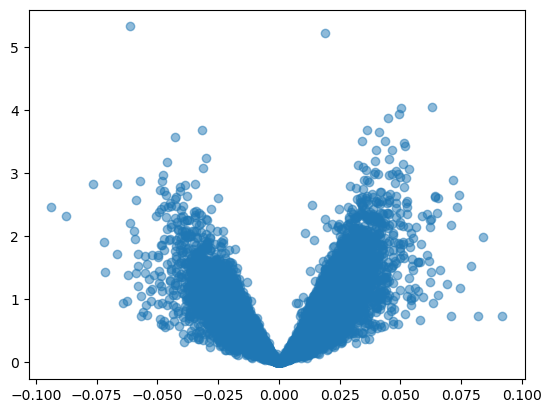

In [25]:
df_mllib_stats["logFC 0-1"] = np.log2(df_mllib_stats["m_1"] / df_mllib_stats["m_0"])
df_mllib_stats["-log10(p-value 0-1)"] = -np.log10(df_mllib_stats["t1"].map(lambda x: x.pvalue))

# Volcano plot
plt.scatter(
    df_mllib_stats["logFC 0-1"],
    df_mllib_stats["-log10(p-value 0-1)"],
    alpha=0.5
)

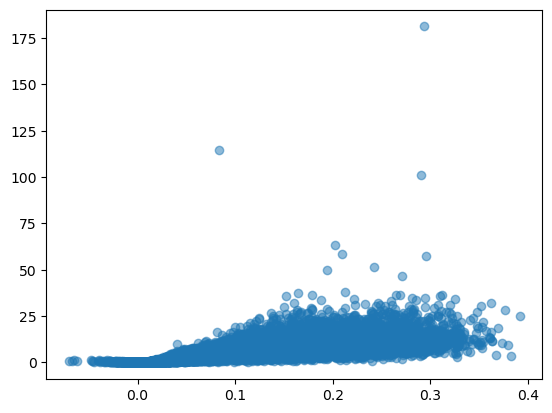

In [26]:
df_mllib_stats["logFC 6-7"] = np.log2(df_mllib_stats["m_7"] / df_mllib_stats["m_6"])
df_mllib_stats["-log10(p-value 6-7)"] = -np.log10(df_mllib_stats["t2"].map(lambda x: x.pvalue))

# Volcano plot
plt.scatter(
    df_mllib_stats["logFC 6-7"],
    df_mllib_stats["-log10(p-value 6-7)"],
    alpha=0.5
)

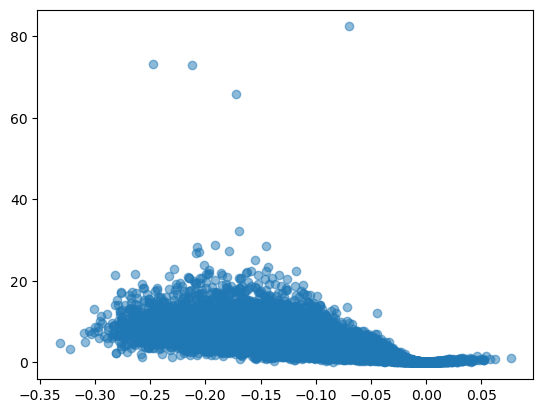

In [27]:
df_mllib_stats["logFC 7-8"] = np.log2(df_mllib_stats["m_8"] / df_mllib_stats["m_7"])
df_mllib_stats["-log10(p-value 7-8)"] = -np.log10(df_mllib_stats["t3"].map(lambda x: x.pvalue))

# Volcano plot
plt.scatter(
    df_mllib_stats["logFC 7-8"],
    df_mllib_stats["-log10(p-value 7-8)"],
    alpha=0.5
)

In [28]:
# An even better representation is to display the difference function
# Group by read 1, compute average of all intensities, then to the difference
# between the average of each consecutive pair of intensities.
# Then plot it.

fp = "01b_df_mllib_diff.csv"
if Path(fp).exists():
    df_mllib_diff = pd.read_csv(fp)
else:
    dfs = []
    for cdr3, df_g in df_mllib_clean.groupby("read 1"):

        # Melt df_g to have one row per intensity
        df_g_melted = df_g.melt(
            id_vars=["read 1", "barcode"],
            value_vars=[f"intensity {i}" for i in range(14)],
            var_name="intensity",
            value_name="intensity_value"
        )
        df_g_melted["intensity"] = df_g_melted["intensity"].apply(lambda x: int(x.split(" ")[1]))

        # Compute average of each intensity
        df_g_melted_avg = df_g_melted.groupby("intensity").mean().reset_index()

        # Compute difference between consecutive intensities
        df_g_melted_avg["diff"] = df_g_melted_avg["intensity_value"].diff().fillna(0)
        df_g_melted_avg["diff_perc"] = df_g_melted_avg["intensity_value"].pct_change().fillna(0)

        # Add cdr3
        df_g_melted_avg["cdr3"] = cdr3

        dfs.append(df_g_melted_avg)

    df_mllib_diff = pd.concat(dfs)
    df_mllib_diff.to_csv(fp)

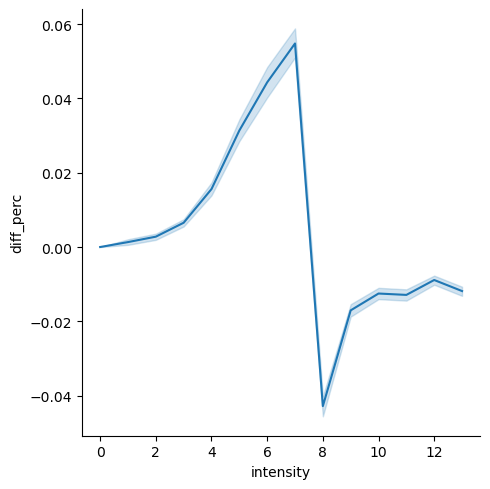

In [29]:
# Plot the diff vs intensity
sns.relplot(
    data=df_mllib_diff.sample(10000),
    x="intensity",
    y="diff_perc",
    kind="line",
)

<AxesSubplot: xlabel='intensity', ylabel='diff_perc'>

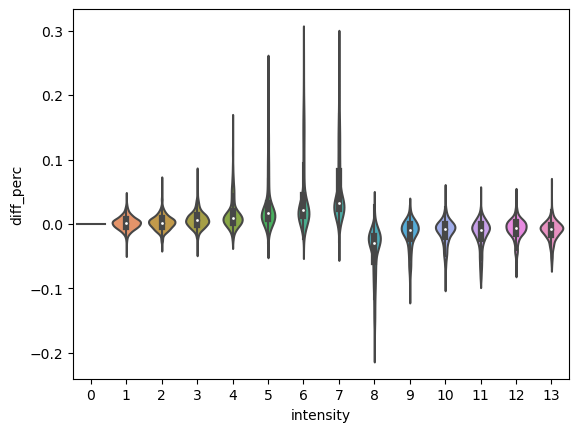

In [30]:
# Plot the diff vs intensity
sns.violinplot(
    data=df_mllib_diff.sample(10000),
    x="intensity",
    y="diff_perc",
)

## Extracting Kd values

Note: Most antibodies have KD values in the low micromolar (10-6) to nanomolar (10-7 to 10-9) range. High-affinity antibodies are generally considered to be in the low nanomolar range (10-9), with very high-affinity antibodies being in the picomolar (10-12) range.

Source: https://www.abcam.com/primary-antibodies/kd-value-a-quantitive-measurement-of-antibody-affinity

ERCEPTIN (Trastuzumab) is a recombinant DNA-derived humanized monoclonal antibody that selectively
binds with high affinity in a cell-based assay (Kd = 5 nM). Source: https://www.accessdata.fda.gov/drugsatfda_docs/label/1998/trasgen092598lb.pdf
- in the paper, they claim that the Kd is 0.1 - 0.5 nM.

Check the paper again, they claim that intensity 8 / at 100 nM?? better correlates with binding data...
- check based on which intensity to split the sequences
- 2) Think which sequences to use: affmat, mllib, merge both?

In [31]:
# Measured concentrations in (M), every 45' for reaching equilibrium
map_intensity_to_conc = {
    "intensity 0": 0 + 1e-20,  # to later avoid division by 0
    "intensity 1": 100e-12,
    "intensity 2": 333e-12,
    "intensity 3": 1e-9,
    "intensity 4": 3.33e-9,
    "intensity 5": 10e-9,
    "intensity 6": 33.3e-9,
    "intensity 7": 100e-9,
    "intensity 8": 0,
    "intensity 9": 0,
    "intensity 10": 0,
    "intensity 11": 0,
    "intensity 12": 0,
    "intensity 13": 0,    
}

R = 8.31446261815324  # universal gas constant, J/(mol*K)
T = 293.15  # temperature, K (20C)

In [32]:
# Curve fitting
import multiprocessing
from scipy.optimize import curve_fit


def estimate_kd_and_energies(df_g: pd.DataFrame) -> dict:
    cdr3 = df_g["read 1"].iloc[0]
    # Melt df_g to have one row per intensity
    df_g_melted = df_g.melt(
        id_vars=["read 1", "barcode"],
        value_vars=[f"intensity {i}" for i in range(14)],
        var_name="intensity",
        value_name="intensity_value"
    )
    df_g_melted["intensity_int"] = df_g_melted["intensity"].apply(lambda x: int(x.split(" ")[1]))
    df_g_melted["conc"] = df_g_melted["intensity"].map(map_intensity_to_conc)  # in M
    df_g_melted.dropna(inplace=True)

    F_min = df_g_melted.loc[df_g_melted["intensity"] == "intensity 0"]["intensity_value"].min()
    F_max = df_g_melted.loc[df_g_melted["intensity"] == "intensity 7"]["intensity_value"].max()
    
    def func(conc, Kd):
        """
        Function to fit to the data. Computes intensity.
        Based on the formula from the paper
        """
        return F_max / (1 + Kd / conc) + F_min

    # Fit the curve
    popt, pcov = curve_fit(func, df_g_melted["conc"], df_g_melted["intensity_value"])
    Kd_est = popt[0]
    E_est = R * T * np.log(Kd_est) / 1000 # in kJ/mol

    record = {
        "cdr3": cdr3,
        "Kd_est": Kd_est,
        "E_est": E_est,
        "F_min": F_min,
        "F_max": F_max,
        # Add average value for all intensities
        **df_g_melted.groupby("intensity").mean(numeric_only=True)["intensity_value"].to_dict(),
    }
    
    return record


## Non-parallel version
# records = []
# for _, df_g in df_mllib_clean.groupby("read 1"):

#     record = estimate_kd_and_energies(df_g)
#     records.append(record)

# df_kd = pd.DataFrame(records)


# Parallel version
fp = "01b_df_kd.csv"
if Path(fp).exists():
    df_kd = pd.read_csv(fp)
else:
    with multiprocessing.Pool(processes=20) as pool:
        res = pool.starmap(
            estimate_kd_and_energies,
            [(df_g,) for _, df_g in df_mllib_clean.groupby("read 1")],
        )

    df_kd = pd.DataFrame(res)
    df_kd["affinity_est"] = 1 / df_kd["Kd_est"]  # Kaff = 1/Kd
    df_kd.to_csv(fp)

<AxesSubplot: ylabel='Frequency'>

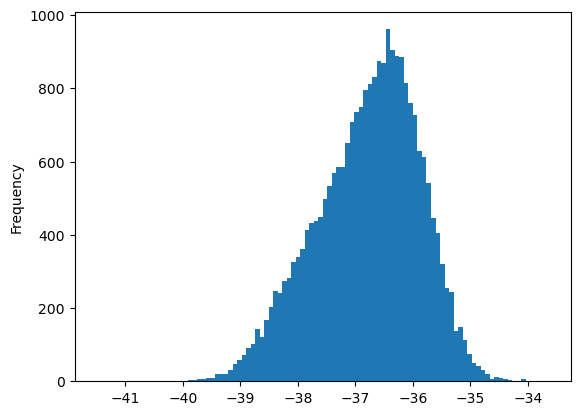

In [33]:
df_kd["E_est"].plot.hist(bins=100)

<AxesSubplot: ylabel='Frequency'>

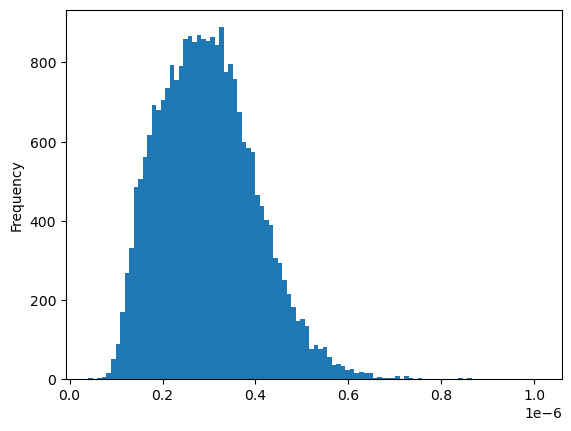

In [34]:
df_kd["Kd_est"].plot.hist(bins=100)

<AxesSubplot: ylabel='Frequency'>

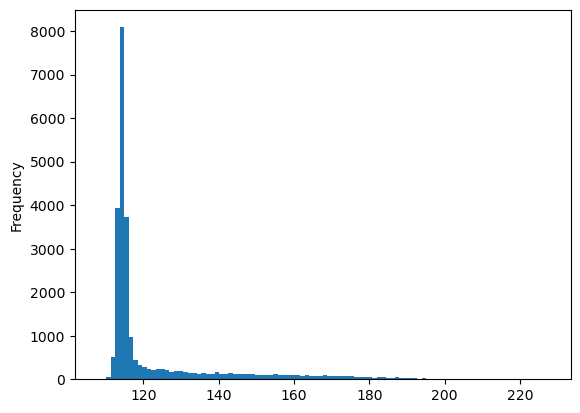

In [35]:
df_kd["intensity 8"].plot.hist(bins=100)

In [36]:
min(df_kd["Kd_est"])  # 400 pM

4.0551351379436124e-08

## Deciding on a metric

- Puneet recomended I8.
- In paper they recommend I4/5 based on corelations with BLI binding data of 21 clones.
- Kd seem to not correlate as well with BLI binding data.
- Distribution for I4/5 is not similar as the ones for energies we used in Absolut data.
    - However the ranking of sequences may stay the same, in which case it doesn't matter how we select, or?
- Mathematically, we worked out that $\log(\frac{1}{R-F_{min}}) \sim \Delta G$, but it's unclear if this is better.
    - generally, $F_{min}$ should be the same for all! Moreover, since $R-F_{min} > 0$ in theory, it means that the ranking should not be change with respect to the ranking from $\log(1/R)$. But introducing empirically the $F_{min}$ may change the ranking, because of estimation errors in the $F_{min}$.

Practically:
1. Check correlations between i4, i5, i8, Kd and $\log(\frac{1}{R-F_{min}})$ for intensity 4, just to have it.
2. Use the i4, because ultimately this is what was checked. The formula above would use another variable $F_{min}$ with unclear implications.
    - Alternatively, use i8, because that's what the authors used and it worked for generating novel sequences.

<AxesSubplot: ylabel='Frequency'>

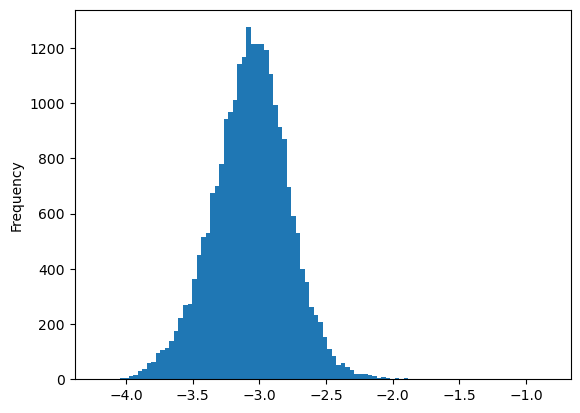

In [37]:
# Compute the R4 transformed:
df_kd["R4_transformed"] = np.log(1 / (df_kd["intensity 4"] - df_kd["F_min"]))

# The R4 transformed does look like a normal distribution, best distribution seen so far!
df_kd["R4_transformed"].plot.hist(bins=100)

In [38]:
# Correlations between i4, i5, i8, Kd_est and log(1/(i4-F_min)).
df_kd[["intensity 4", "intensity 5", "intensity 8", "Kd_est", "R4_transformed"]].corr()

,intensity 4,intensity 5,intensity 8,Kd_est,R4_transformed
intensity 4,1.000000,0.970318,0.932128,-0.517811,-0.572889
intensity 5,0.970318,1.000000,0.968224,-0.542600,-0.550130
intensity 8,0.932128,0.968224,1.000000,-0.561203,-0.535091
Kd_est,-0.517811,-0.542600,-0.561203,1.000000,0.871225
R4_transformed,-0.572889,-0.550130,-0.535091,0.871225,1.000000


The main question: are the ranking consistent?
- Not really, see below.

In [39]:
# Check the rankings obtained by R4_transformed and intensity 4
df_kd["R4_transformed_rank"] = (-df_kd["R4_transformed"]).rank()
df_kd["intensity 4_rank"] = df_kd["intensity 4"].rank()
df_kd["intensity 5_rank"] = df_kd["intensity 5"].rank()
df_kd["intensity 8_rank"] = df_kd["intensity 8"].rank()
df_kd["Kd_est_rank"] = (-df_kd["Kd_est"]).rank()

In [40]:
# Compute kendall tau among the above
from scipy.stats import kendalltau

# Apply kendalltau to all pairs from above, collect results
# in a symmetric matrix, as in pd.DataFrame.corr()
cols_rank = ["R4_transformed_rank", "intensity 4_rank", "intensity 5_rank", "intensity 8_rank", "Kd_est_rank"]
df_kd_ranks = df_kd[cols_rank].copy()

kendalltau_matrix = np.zeros((4, 4))
for i in range(4):
    for j in range(4):
        kendalltau_matrix[i, j] = kendalltau(
            df_kd_ranks.iloc[:, i],
            df_kd_ranks.iloc[:, j],
        )[0]

kendalltau_matrix = pd.DataFrame(data=kendalltau_matrix, columns=cols_rank, index=cols_rank)
kendalltau_matrix

ValueError: Shape of passed values is (4, 4), indices imply (5, 5)

## Getting the classification of sequences from Porebski

In [ ]:
print(df_kd.shape)
df_kd.head()

(24790, 25)


,cdr3,Kd_est,E_est,F_min,F_max,intensity 0,intensity 1,intensity 10,intensity 11,intensity 12,...,intensity 6,intensity 7,intensity 8,intensity 9,affinity_est,R4_transformed,R4_transformed_rank,intensity 4_rank,intensity 5_rank,Kd_est_rank
0,ADVAYCCTPTCAKWPEYFQWW,2.566097e-07,-36.989043,94.461716,141.05211,111.342196,108.361792,117.222275,117.295862,115.129606,...,119.406109,126.040790,118.581446,118.161568,3.896969e+06,-2.803737,4143.0,8037.0,5634.0,15437.0
1,CDGACCDTPTCAKWPEYFQHW,3.757516e-07,-36.059492,93.957440,144.95908,110.953692,108.887190,113.325916,114.728697,111.925250,...,113.291626,117.351588,113.952191,113.828101,2.661333e+06,-2.962505,8973.0,19648.0,14135.0,5457.0
2,CDPAYYSSSRCLTWPEYFQHW,3.962092e-07,-35.930277,94.155020,149.19969,109.530200,110.394295,112.850615,111.254278,112.188794,...,113.032409,117.512647,114.270451,112.941200,2.523919e+06,-2.800725,4076.0,4895.0,15894.0,4211.0
3,CDRAYCDTPTCAKWPEYFQHW,4.037524e-07,-35.884309,96.954380,133.01643,109.273767,110.639957,117.067877,112.947864,112.327054,...,116.078040,116.459165,113.967739,114.493203,2.476765e+06,-2.706991,2305.0,16165.0,15873.0,3809.0
4,CDRAYCDTPTCAKWPEYFQPW,3.318797e-07,-36.362107,91.821106,142.25514,110.699016,109.528347,112.976801,112.402118,112.344085,...,114.181798,116.347380,113.271742,114.328324,3.013140e+06,-2.959515,8868.0,9384.0,9362.0,8763.0


<AxesSubplot: ylabel='Frequency'>

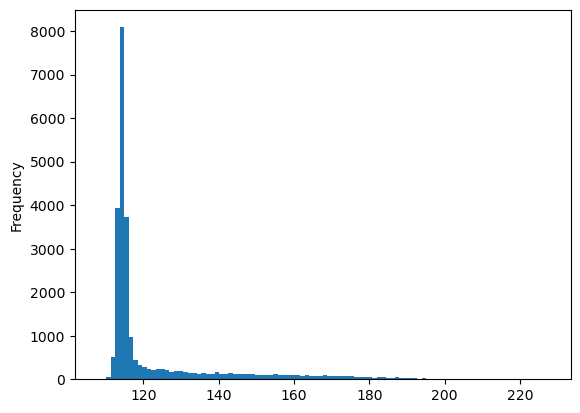

In [ ]:
df_kd["intensity 8"].plot.hist(bins=100)

In [ ]:
# Compute quantiles for intensity 8 and
# get the number of sequences in each quantile
df_kd["intensity 8_quantile"] = pd.qcut(df_kd["intensity 8"], 10)
df_kd["intensity 8_quantile"].value_counts()

(107.78999999999999, 113.382]    2479
(113.382, 113.846]               2479
(113.846, 114.197]               2479
(114.197, 114.55]                2479
(114.55, 114.936]                2479
(114.936, 115.509]               2479
(115.509, 117.482]               2479
(117.482, 129.174]               2479
(129.174, 151.864]               2479
(151.864, 227.492]               2479
Name: intensity 8_quantile, dtype: int64

In [ ]:
from scipy import stats

th_non_weak = 122
th_weak_high = 150

# Quantiles of the thresholds above based on intensity 8
print(stats.percentileofscore(df_kd["intensity 8"], th_non_weak))
print(stats.percentileofscore(df_kd["intensity 8"], th_weak_high))

print(
    (df_kd["intensity 8"] > th_weak_high).sum(), f"# sequences with intensity 8 > {th_weak_high}\n",
    ((df_kd["intensity 8"] > th_non_weak) & ((df_kd["intensity 8"] <= th_weak_high))).sum(), f"# sequences {th_non_weak}-{th_weak_high}\n",
    (df_kd["intensity 8"] <= th_non_weak).sum(), f"# sequences <{th_non_weak}\n",
)

74.94150867285195
89.35861234368697
2638 # sequences with intensity 8 > 150
 3574 # sequences 122-150
 18578 # sequences <122



In [ ]:
# Classify binder_type based on intensity 8
# comparison with the 2 thresholds
df_kd["binder_type"] = "HR2P_95low"
df_kd.loc[df_kd["intensity 8"] > th_weak_high, "binder_type"] = "HR2P_high"
df_kd.loc[
    (df_kd["intensity 8"] > th_non_weak) & ((df_kd["intensity 8"] <= th_weak_high)),
    "binder_type",
] = "HR2P_looserX"

print(df_kd["binder_type"].value_counts())
df_kd.head()

HR2P_95low      18578
HR2P_looserX     3574
HR2P_high        2638
Name: binder_type, dtype: int64


,cdr3,Kd_est,E_est,F_min,F_max,intensity 0,intensity 1,intensity 10,intensity 11,intensity 12,...,intensity 8,intensity 9,affinity_est,R4_transformed,R4_transformed_rank,intensity 4_rank,intensity 5_rank,Kd_est_rank,intensity 8_quantile,binder_type
0,ADVAYCCTPTCAKWPEYFQWW,2.566097e-07,-36.989043,94.461716,141.05211,111.342196,108.361792,117.222275,117.295862,115.129606,...,118.581446,118.161568,3.896969e+06,-2.803737,4143.0,8037.0,5634.0,15437.0,"(117.482, 129.174]",HR2P_95low
1,CDGACCDTPTCAKWPEYFQHW,3.757516e-07,-36.059492,93.957440,144.95908,110.953692,108.887190,113.325916,114.728697,111.925250,...,113.952191,113.828101,2.661333e+06,-2.962505,8973.0,19648.0,14135.0,5457.0,"(113.846, 114.197]",HR2P_95low
2,CDPAYYSSSRCLTWPEYFQHW,3.962092e-07,-35.930277,94.155020,149.19969,109.530200,110.394295,112.850615,111.254278,112.188794,...,114.270451,112.941200,2.523919e+06,-2.800725,4076.0,4895.0,15894.0,4211.0,"(114.197, 114.55]",HR2P_95low
3,CDRAYCDTPTCAKWPEYFQHW,4.037524e-07,-35.884309,96.954380,133.01643,109.273767,110.639957,117.067877,112.947864,112.327054,...,113.967739,114.493203,2.476765e+06,-2.706991,2305.0,16165.0,15873.0,3809.0,"(113.846, 114.197]",HR2P_95low
4,CDRAYCDTPTCAKWPEYFQPW,3.318797e-07,-36.362107,91.821106,142.25514,110.699016,109.528347,112.976801,112.402118,112.344085,...,113.271742,114.328324,3.013140e+06,-2.959515,8868.0,9384.0,9362.0,8763.0,"(107.78999999999999, 113.382]",HR2P_95low


# Adapting and saving to Miniabsolut

In [ ]:
### Adapt df to fit as much as possible
### the format we used with Absolut data.
# ID_slide_Variant	CDR3	Best	Slide	Energy	Structure	Source	Antigen
df_kd["ID_slide_Variant"] = None
df_kd["CDR3"] = df_kd["cdr3"]
df_kd["Best"] = True
df_kd["Slide"] = df_kd["cdr3"]
df_kd["Energy"] = None
df_kd["Structure"] = None
df_kd["Source"] = df_kd["binder_type"]
df_kd["Antigen"] = "HR2P"
df_kd = df_kd[["ID_slide_Variant", "CDR3", "Best", "Slide", "Energy", "Structure", "Source", "Antigen", "binder_type"]].copy()

# Check no duplicates
assert df_kd["CDR3"].duplicated().sum() == 0, "There are duplicated CDR3s"

In [ ]:
df_kd.head()

,ID_slide_Variant,CDR3,Best,Slide,Energy,Structure,Source,Antigen,binder_type
0,None,ADVAYCCTPTCAKWPEYFQWW,True,ADVAYCCTPTCAKWPEYFQWW,None,None,HR2P_95low,HR2P,HR2P_95low
1,None,CDGACCDTPTCAKWPEYFQHW,True,CDGACCDTPTCAKWPEYFQHW,None,None,HR2P_95low,HR2P,HR2P_95low
2,None,CDPAYYSSSRCLTWPEYFQHW,True,CDPAYYSSSRCLTWPEYFQHW,None,None,HR2P_95low,HR2P,HR2P_95low
3,None,CDRAYCDTPTCAKWPEYFQHW,True,CDRAYCDTPTCAKWPEYFQHW,None,None,HR2P_95low,HR2P,HR2P_95low
4,None,CDRAYCDTPTCAKWPEYFQPW,True,CDRAYCDTPTCAKWPEYFQPW,None,None,HR2P_95low,HR2P,HR2P_95low


In [ ]:
# Run and build into the Absolut dataset
# the new experimental data from Brij.

RUN_FLAG = False

if RUN_FLAG:
    ag = "HR2P"  # Her2 from Brij dataset
    df_kd = df_kd.copy()

    N_train = 2000
    N_test = 500

    make_splits = [False] + [True]*5
    seed = [None] + list(range(5))

    for MAKE_SPLITS, seed in zip(make_splits, seed):
        build_dataset_into_Absolut(N_train, N_test, MAKE_SPLITS, seed, ag, df_kd)

In [ ]:
len(df_kd["CDR3"][0])

21

In [ ]:
slides_high = df_kd.loc[df_kd["binder_type"] == "HR2P_high", "CDR3"].values
slides_weak = df_kd.loc[df_kd["binder_type"] == "HR2P_looserX", "CDR3"].values
slides_nonb = df_kd.loc[df_kd["binder_type"] == "HR2P_95low", "CDR3"].values

In [ ]:
jsd_1 = utils.jensen_shannon_divergence_slides(slides_high, slides_weak)
jsd_2 = utils.jensen_shannon_divergence_slides(slides_high, slides_nonb)
jsd_3 = utils.jensen_shannon_divergence_slides(slides_weak, slides_nonb)
print(jsd_1, jsd_2, jsd_3)

2.252528244238772 4.350360192362068 3.2250848724707644
